<a href="https://colab.research.google.com/github/aoru45/FLAME_TO_HACK/blob/main/FLAME_to_HACK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clone Hack Repo

In [ ]:
!git clone https://github.com/ZoneLikeWonderland/HACK-Model.git
!mv HACK-Model/* ./

Cloning into 'HACK-Model'...
remote: Enumerating objects: 28, done.
remote: Total 28 (delta 0), reused 0 (delta 0), pack-reused 28
Receiving objects: 100% (28/28), 47.38 MiB | 31.34 MiB/s, done.


Put your username and password to "**USERNAME_HERE**" and "**PASSWORD_HERE**",you shold register a username and password from [FLAME](https://flame.is.tue.mpg.de/) to get the dataset.

In [ ]:
!wget --post-data "username=USERNAME_HERE&password=PASSWORD_HERE" 'https://download.is.tue.mpg.de/download.php?domain=flame&sfile=TextureSpace.zip&resume=1' -O './TextureSpace.zip' --no-check-certificate --continue
!unzip TextureSpace.zip
!wget https://github.com/aoru45/FLAME_TO_HACK/blob/main/head_template_mesh.obj

--2023-08-24 13:49:32--  https://download.is.tue.mpg.de/download.php?domain=flame&sfile=TextureSpace.zip&resume=1
Resolving download.is.tue.mpg.de (download.is.tue.mpg.de)... 192.124.27.139
Connecting to download.is.tue.mpg.de (download.is.tue.mpg.de)|192.124.27.139|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: download.php?domain=flame&sfile=TextureSpace.zip&resume=1 [following]
--2023-08-24 13:49:34--  https://download.is.tue.mpg.de/download.php?domain=flame&sfile=TextureSpace.zip&resume=1
Reusing existing connection to download.is.tue.mpg.de:443.
HTTP request sent, awaiting response... 200 OK
Length: 1158570802 (1.1G) [application/octet-stream]
Saving to: ‘./TextureSpace.zip’

./TextureSpace.zip  100%[===================>]   1.08G  18.0MB/s    in 63s     

2023-08-24 13:50:37 (17.5 MB/s) - ‘./TextureSpace.zip’ saved [1158570802/1158570802]

Archive:  TextureSpace.zip
  inflating: FLAME_texture.npz       
  inflating: Readme.pdf              


In [1]:
!pip install roma
!pip install trimesh

Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple/
Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple/
     |████████████████████████████████| 685 kB 5.9 MB/s eta 0:00:01


In [1]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith(("1.13.", "2.0.")) and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable

In [1]:
%matplotlib inline
import numpy as np
import cv2 as cv
import os
import sys
import tqdm
import hack_model
import helper
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pytorch3d.structures import Meshes, Pointclouds
from pytorch3d.ops import knn_points, knn_gather
from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency,
)
from pytorch3d.ops import sample_points_from_meshes
import pytorch3d
from pytorch3d.io import load_obj
from pytorch3d.renderer.mesh import rasterize_meshes
from pytorch3d.renderer import TexturesUV
import trimesh
from pytorch3d.vis.plotly_vis import plot_scene
from pytorch3d.renderer import (look_at_view_transform,
                                FoVPerspectiveCameras,
                                FoVOrthographicCameras,
                                MeshRenderer,
                                MeshRasterizer,
                                RasterizationSettings,
                                SoftPhongShader,
                                HardPhongShader,
                                SoftGouraudShader,
                                HardGouraudShader,
                                TexturesVertex,
                                PointLights)
import torch
from tqdm.notebook import tqdm
device = torch.device("cuda")

In [12]:
flame_vs, flame_faces_, flame_aux = load_obj("assets/FLAME_w_HIFI3D_UV.obj")
flame_vs = flame_vs[None, ...].to(device)
flame_fvs = flame_faces_.verts_idx[None, ...].to(device)
flame_vts = flame_aux.verts_uvs[None, ...].to(device)  # (N, V, 2)
flame_fvts = flame_faces_.textures_idx[None, ...].to(device)  # (N, F, 3)
flame_mesh = Meshes(verts = flame_vs, faces = flame_fvs)
flame_pcl = Pointclouds(flame_mesh.verts_padded())

eye_face_mask = torch.ones(flame_fvs.size(1)).bool()
eye_verts_mask = torch.ones(flame_vs.size(1)).bool().to(device)
flame_nose_msk = [464, 465, 466, 467, 473, 474, 475, 489, 491, 492, 493, 494, 495, 754, 755, 756, 760, 761, 762, 763, 768, 769, 770, 771, 772, 773, 775, 1379, 1380, 1381, 1382, 1393, 1394, 1407, 1408, 1409, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 2163, 2164, 2169, 2170, 2171, 2173, 2174, 2228, 2229, 2230, 2231, 2234, 2235, 2236, 2237, 2242, 2243, 2245, 2246, 2247, 2249, 3175, 3176, 3177, 3178, 3179, 3180, 3181, 3182, 3380, 3576]
for i in range(flame_fvts.size(1)):
    if flame_vts[0, flame_fvs[0, i, 0], 0] > 1:
        eye_face_mask[i] = 0
        eye_verts_mask[flame_fvs[0, i, 0]] = 0
    if flame_vts[0, flame_fvs[0, i, 1], 0] > 1:
        eye_face_mask[i] = 0
        eye_verts_mask[flame_fvs[0, i, 1]] = 0
    if flame_vts[0, flame_fvs[0, i, 2], 0] > 1:
        eye_face_mask[i] = 0
        eye_verts_mask[flame_fvs[0, i, 2]] = 0
    c1 = flame_fvs[0, i, 0].item() in flame_nose_msk
    c2 = flame_fvs[0, i, 1].item() in flame_nose_msk
    c3 = flame_fvs[0, i, 2].item() in flame_nose_msk
    if c1 and c2 and c3:
        eye_face_mask[i] = 0
        eye_verts_mask[flame_fvs[0, i, 0]] = 0
        eye_verts_mask[flame_fvs[0, i, 1]] = 0
        eye_verts_mask[flame_fvs[0, i, 2]] = 0
flame_pcl_no_eye = Pointclouds(flame_mesh.verts_padded()[:, eye_verts_mask])
flame_mesh_no_eye = Meshes(verts = flame_vs, faces = flame_fvs[:, eye_face_mask]).to(device)

In [ ]:
hack = hack_model.HACK().to(device)

S = hack_model.load_pca(r"model/S.npy").to(device)
E = hack_model.load_pca(r"model/E.npy").to(device)
P = hack_model.load_pca(r"model/P.npy").to(device)

Init scale and offset, draw the pointcloud to see the corase difference.

In [3]:
def plot_pointcloud(points, title=""):
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)
    fig = plt.figure(figsize=(5, 5))
    ax = Axes3D(fig)
    ax.scatter3D(x, z, -y, c="b")
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    fig.add_axes(ax)
    plt.show()
import random
def plot_mesh2(mesh1, mesh2, title=""):
    points1 = mesh1.verts_padded()
    points2 = mesh2.verts_padded()
    x1, y1, z1 = points1.clone().detach().cpu().squeeze().unbind(1)
    x2, y2, z2 = points2.clone().detach().cpu().squeeze().unbind(1)

    fig = plt.figure(figsize=(5, 5))
    ax = Axes3D(fig)
    ax.scatter3D(x1, z1, -y1, c="b",s=1)
    ax.scatter3D(x2, z2, -y2, c="r",s=1)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    #dir = random.choice([30, 60, 90, 120])
    dir = 60
    ax.view_init(170, dir)
    fig.add_axes(ax)
    plt.show()

beta_zero = torch.zeros(1, 200).to(device)
theta_zero = torch.zeros(1, 8, 3).to(device)
tau_zero = torch.zeros(1, 1).to(device) # - 0.1
alpha_zero = torch.ones(1, 1).to(device)
bsw_zero = torch.zeros(1, 55).to(device)
hack_faces = trimesh.geometry.triangulate_quads(hack_model.obj_template.fvs)
hack_faces = torch.LongTensor(hack_faces).to(device)
with torch.no_grad():
  hack_verts = hack(theta_zero, tau_zero, alpha_zero, bsw_zero, T=S(beta_zero), E=E(), P=P())["T_transformed"][0]
hack_mesh = Meshes(verts = [hack_verts], faces = [hack_faces])
v1 = hack_mesh.verts_padded()
v2 = flame_mesh.verts_padded()
def size_(v):
  tl, _ = torch.max(v[0], dim = 0)
  br, _ = torch.min(v[0], dim = 0)
  return tl - br
scale_init = size_(v2) / size_(v1)
hack_mesh_scaled = hack_mesh.scale_verts(scale_init)
offset_init = flame_mesh.verts_padded()[0].mean(dim = 0) - hack_mesh_scaled.verts_padded()[0].mean(dim = 0)
hack_mesh_scaled.offset_verts_(offset_init)

# hack_mesh, _ = normalize_mesh(hack_mesh)
# plot_pointcloud(hack_verts[None], "hack")
# plot_pointcloud(torch.tensor(flame_verts)[None], "flame")
#plot_mesh2(flame_mesh, hack_mesh_scaled)
# print(flame_verts.max(), flame_verts.min(), flame_verts.shape)

Prepare some 3D landmarks.

In [4]:
# landmarks
def vertices2landmarks(vertices, faces, lmk_faces_idx, lmk_bary_coords):
  batch_size, num_verts = vertices.shape[:2]
  device = vertices.device
  lmk_faces = torch.index_select(faces, 0, lmk_faces_idx.view(-1)).view(
      batch_size, -1, 3)
  lmk_faces += torch.arange(
      batch_size, dtype=torch.long, device=device).view(-1, 1, 1) * num_verts
  lmk_vertices = vertices.view(-1, 3)[lmk_faces].view(
      batch_size, -1, 3, 3)
  landmarks = torch.einsum('blfi,blf->bli', [lmk_vertices, lmk_bary_coords])
  return landmarks
def select_landmark3d68(vertices, faces, lmk_faces_idx, lmk_bary_coords):
  landmarks3d = vertices2landmarks(vertices, faces,
                                       lmk_faces_idx.unsqueeze(0).repeat(vertices.shape[0], 1),
                                       lmk_bary_coords.unsqueeze(0).repeat(vertices.shape[0], 1, 1))
  return landmarks3d
import pickle
with open("assets/flame_static_embedding_68.pkl", 'rb') as f:
    lmk_indexes_dict = pickle.load(f, encoding='latin1')
    flame_lmk_face_idx = torch.LongTensor(lmk_indexes_dict['lmk_face_idx'].astype(np.int32)).to(device)
    flame_lmk_b_coords = torch.tensor(lmk_indexes_dict['lmk_b_coords']).float().to(device)
flame_ldms = select_landmark3d68(flame_mesh.verts_padded(),flame_mesh.faces_packed(),flame_lmk_face_idx,flame_lmk_b_coords)
hack_ldms_idx = [1225, 1888, 1052, 367, 1719, 1722, 2199, 1447, 966, 3661, 4390, 3927, 3924, 2608, 3272, 4088, 3443, 268, 493, 1914, 2044, 1401, 3615, 4240, 4114, 2734, 2509, 978, 4527, 4942, 4857, 1140, 2075, 1147, 4269, 3360, 1507, 1542, 1537, 1528, 1518, 1511, 3742, 3751, 3756, 3721, 3725, 3732, 5708, 5695, 2081, 0, 4275, 6200, 6213, 6346, 6461, 5518, 5957, 5841, 5702, 5711, 5533, 6216, 6207, 6470, 5517, 5966]
hack_ldms_idx = torch.tensor(hack_ldms_idx, dtype = torch.long).to(device)


Prepare some training parameters.

In [34]:
# flame_mesh, (flame_offset, flame_scale) = normalize_mesh(flame_mesh)
beta = torch.nn.Parameter(torch.zeros(1,200).to(device))
scale = torch.nn.Parameter(scale_init.clone().unsqueeze(0).to(device))
offset_p = torch.nn.Parameter(offset_init.clone().unsqueeze(0).to(device))
theta = torch.nn.Parameter(torch.zeros(1, 8, 3).to(device))
# theta = torch.zeros(1, 8, 3).to(device)
tau = torch.nn.Parameter(torch.zeros(1, 1).to(device))
alpha = torch.nn.Parameter(torch.ones(1, 1).to(device))
#bsw = torch.rand(1, 55).to(device)
bsw = torch.nn.Parameter(torch.zeros(1,55).to(device))
# optimizer = torch.optim.Adam(params = [beta])
# optimizer = torch.optim.Adam([
#              {'params': [beta], "lr": 5e-4},
#              {'params': [bsw, offset_p, scale, theta], 'lr': 1e-3}
#         ],
#          lr=1e-3
#  )
optimizer = torch.optim.AdamW([beta, theta, scale, offset_p, bsw, alpha, tau], lr=5e-3, amsgrad=True)# 

with torch.no_grad():
  zero_vts = hack(theta, tau, alpha, bsw, T=S(beta_zero), E=E(), P=P())["T_transformed"][0]
zero_mesh = Meshes(verts = [zero_vts *0.], faces = [hack_faces])

distance_judge = 1
num_epoch = 30
num_iter = 300
ldm_weight = 1
verts_weight = 0.01


Train form some epochs. It is used to fit the HACK shape to FLAME's mean shape.

In [35]:
faces = trimesh.geometry.triangulate_quads(hack_model.obj_template.fvs)
faces = torch.LongTensor(faces).to(device)

  0%|          | 0/300 [00:00<?, ?it/s]

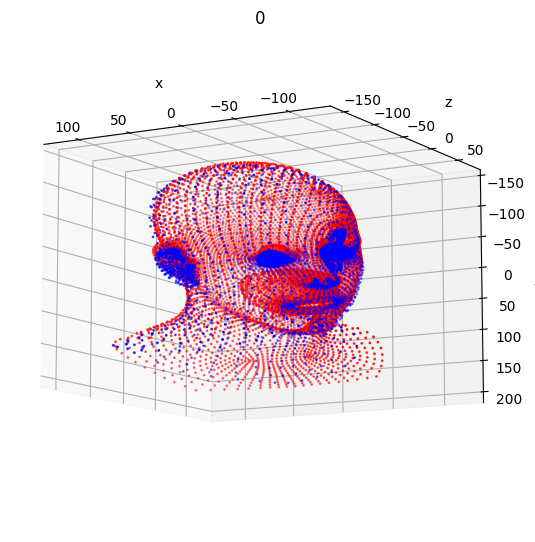

  0%|          | 0/300 [00:00<?, ?it/s]

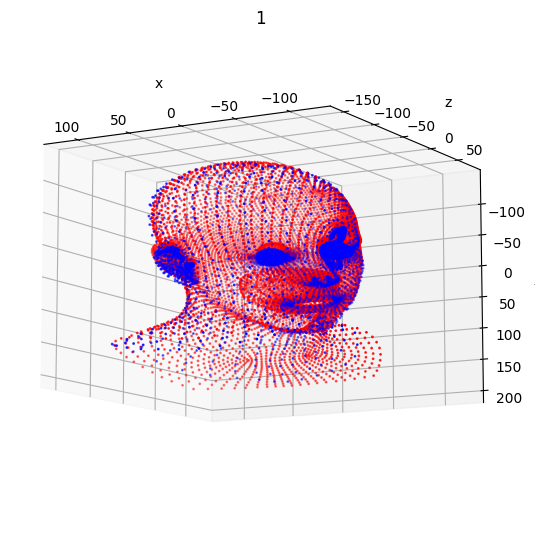

  0%|          | 0/300 [00:00<?, ?it/s]

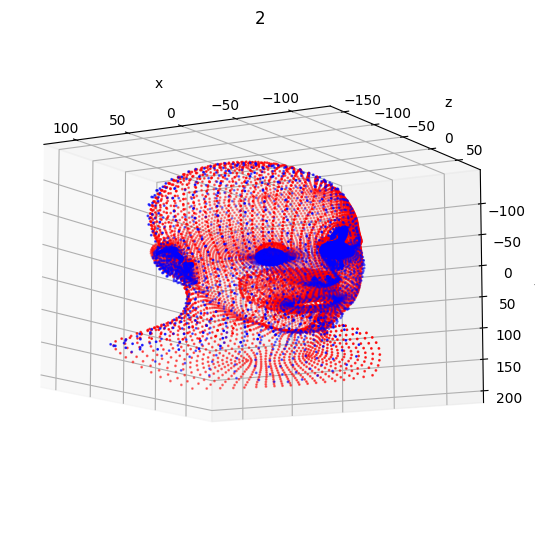

  0%|          | 0/300 [00:00<?, ?it/s]

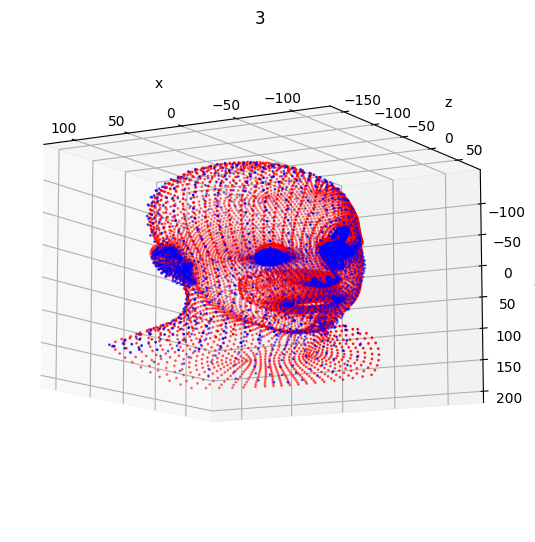

  0%|          | 0/300 [00:00<?, ?it/s]

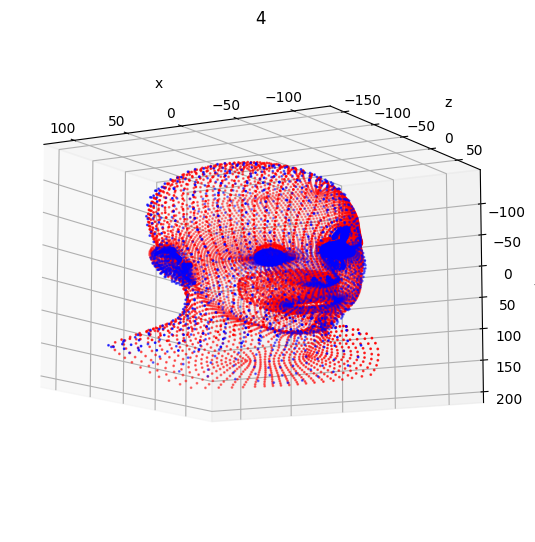

  0%|          | 0/300 [00:00<?, ?it/s]

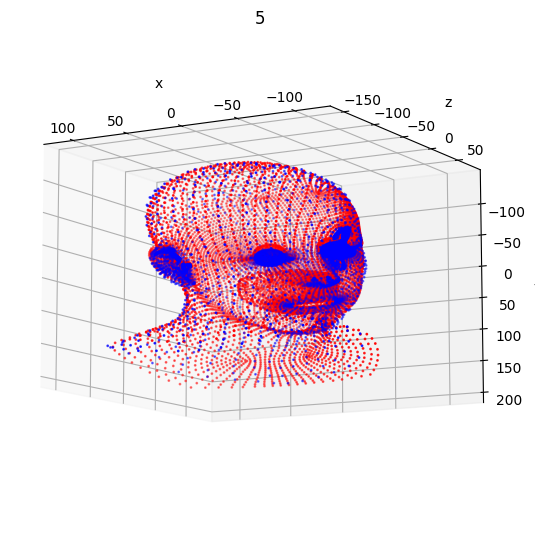

  0%|          | 0/300 [00:00<?, ?it/s]

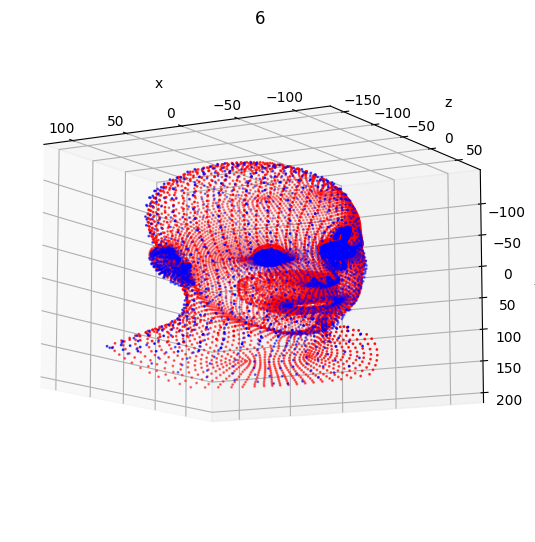

  0%|          | 0/300 [00:00<?, ?it/s]

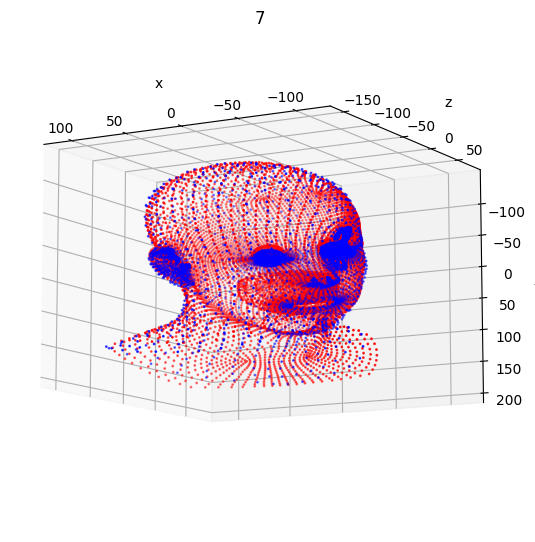

  0%|          | 0/300 [00:00<?, ?it/s]

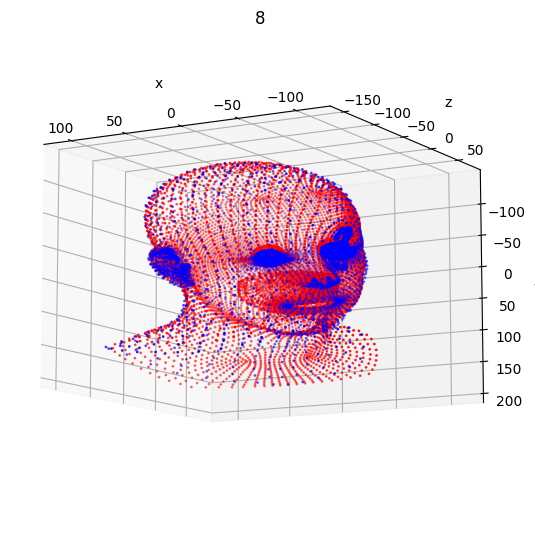

  0%|          | 0/300 [00:00<?, ?it/s]

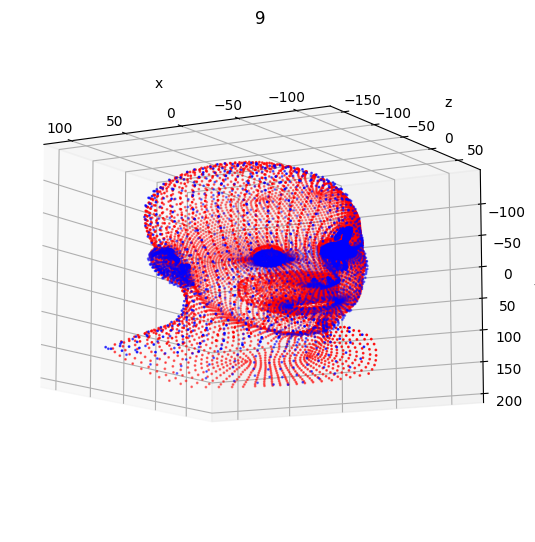

  0%|          | 0/300 [00:00<?, ?it/s]

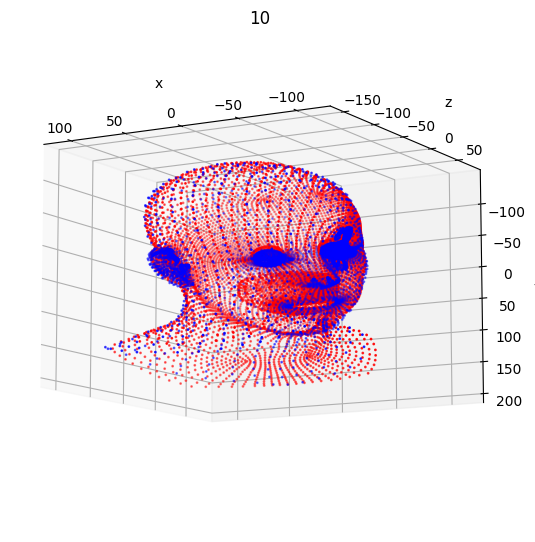

  0%|          | 0/300 [00:00<?, ?it/s]

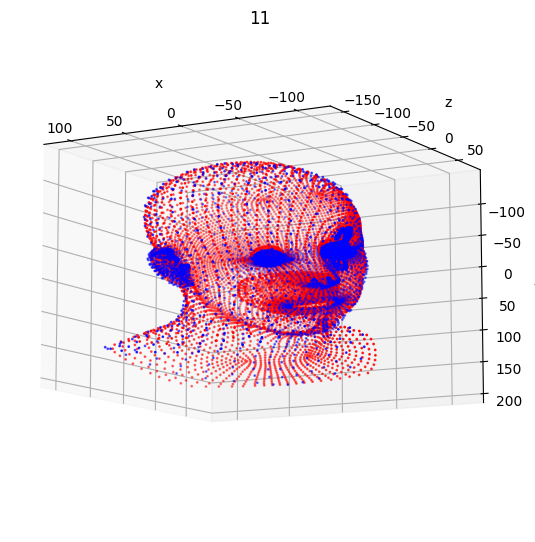

  0%|          | 0/300 [00:00<?, ?it/s]

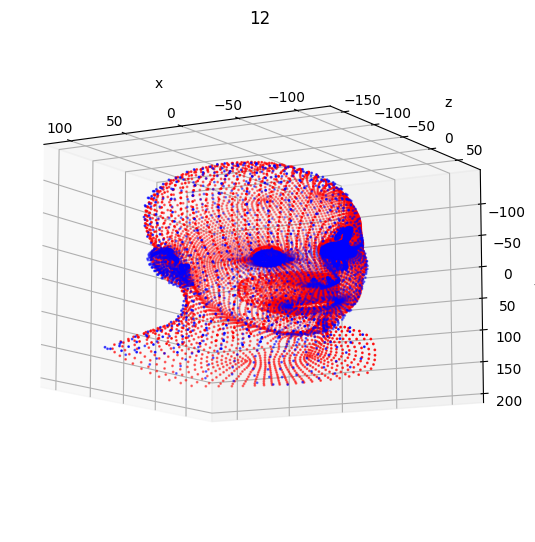

  0%|          | 0/300 [00:00<?, ?it/s]

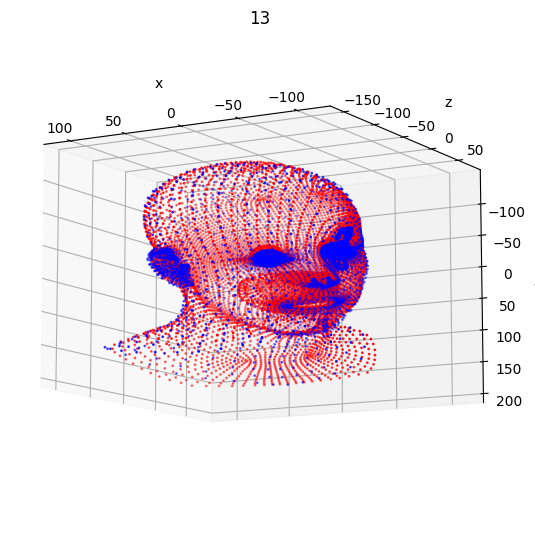

  0%|          | 0/300 [00:00<?, ?it/s]

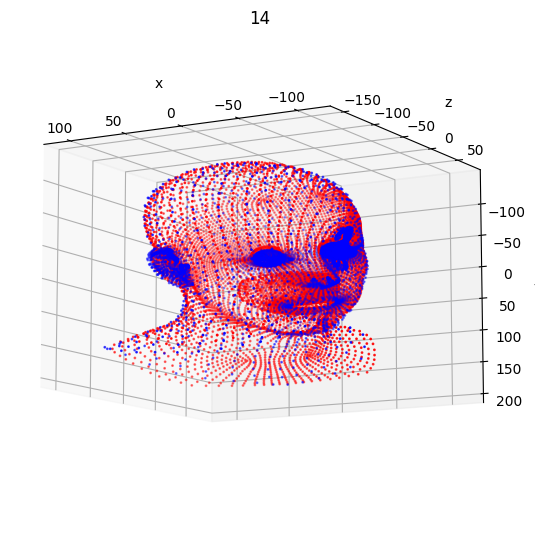

  0%|          | 0/300 [00:00<?, ?it/s]

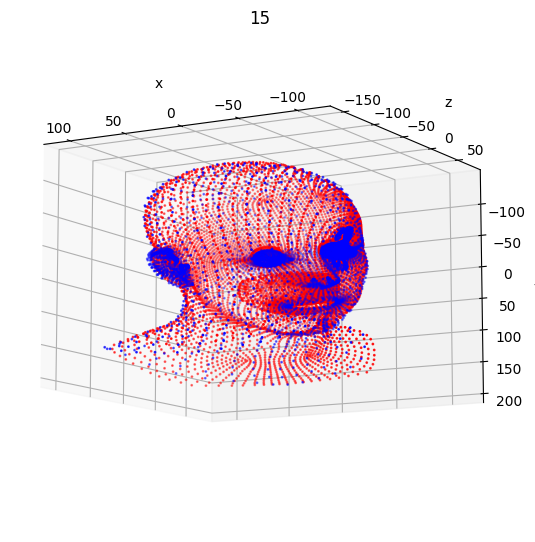

  0%|          | 0/300 [00:00<?, ?it/s]

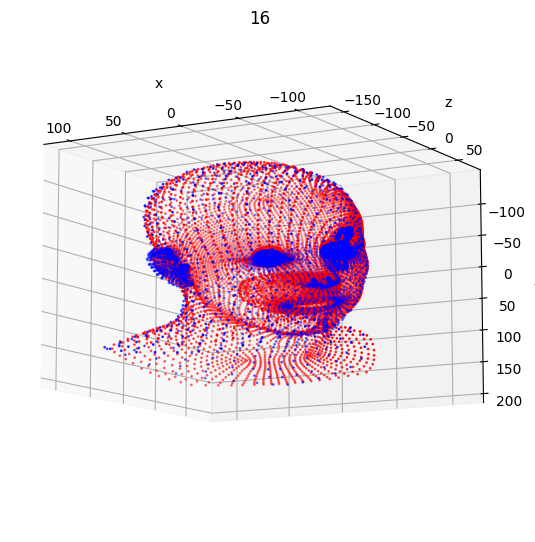

  0%|          | 0/300 [00:00<?, ?it/s]

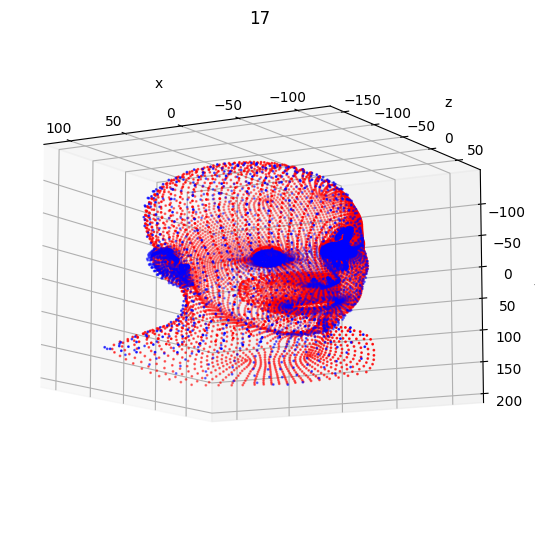

  0%|          | 0/300 [00:00<?, ?it/s]

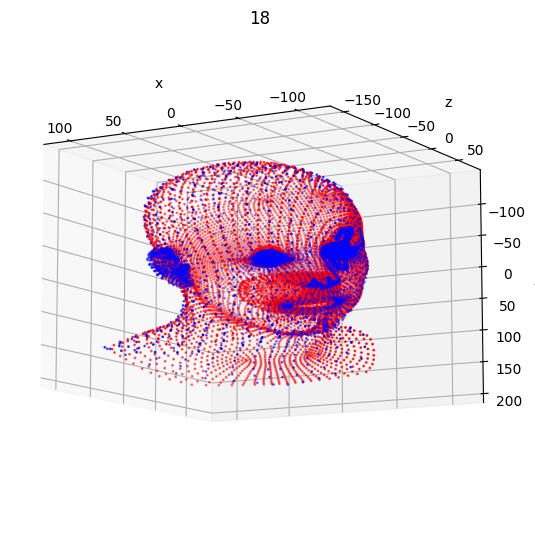

  0%|          | 0/300 [00:00<?, ?it/s]

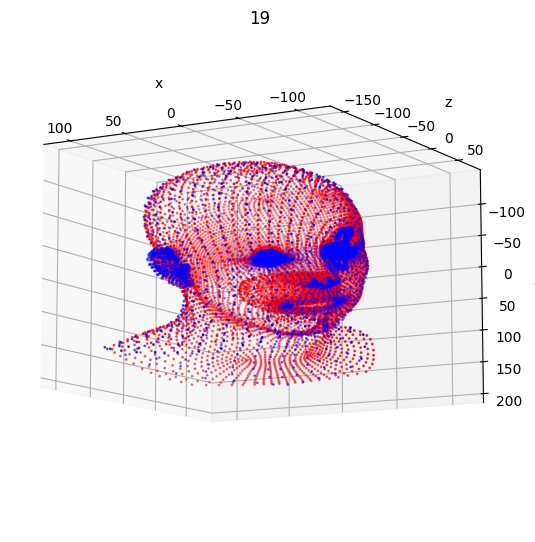

  0%|          | 0/300 [00:00<?, ?it/s]

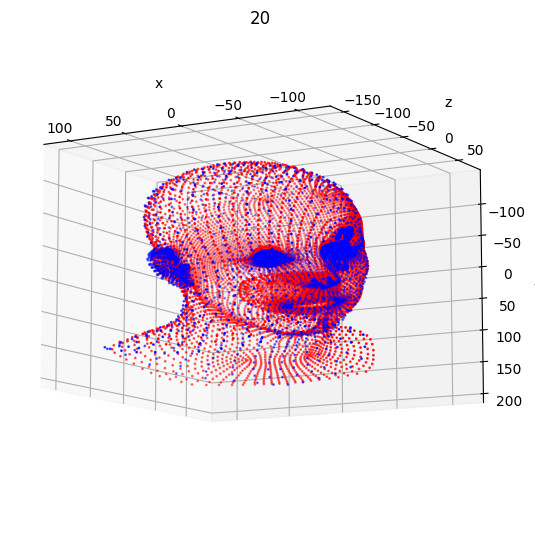

  0%|          | 0/300 [00:00<?, ?it/s]

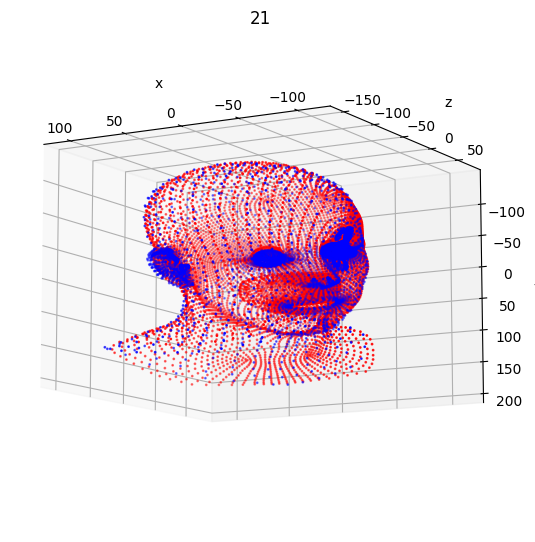

  0%|          | 0/300 [00:00<?, ?it/s]

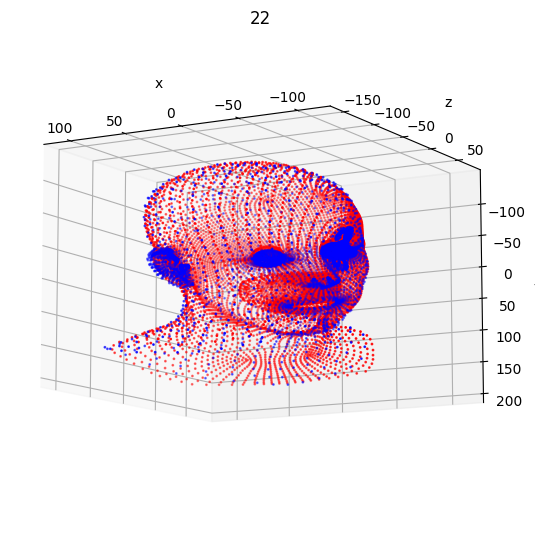

  0%|          | 0/300 [00:00<?, ?it/s]

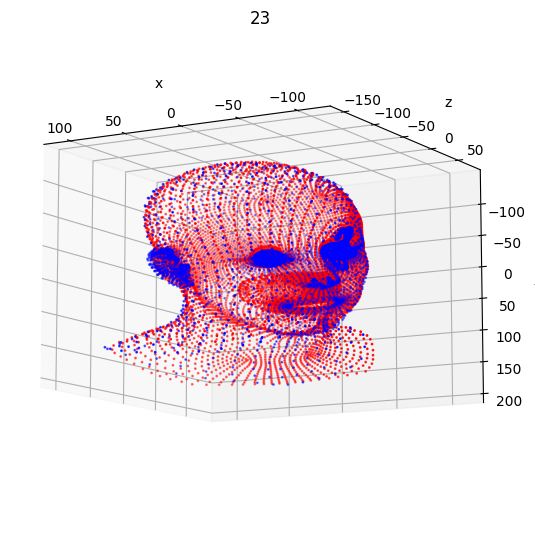

  0%|          | 0/300 [00:00<?, ?it/s]

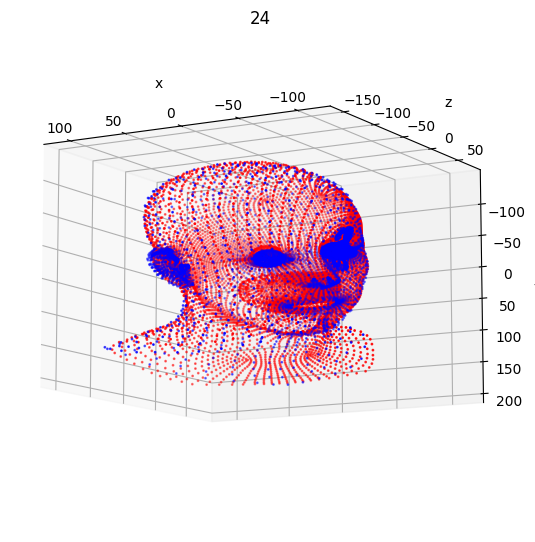

  0%|          | 0/300 [00:00<?, ?it/s]

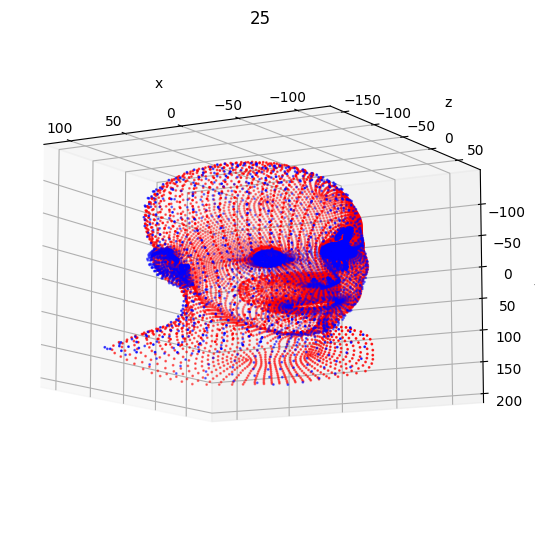

  0%|          | 0/300 [00:00<?, ?it/s]

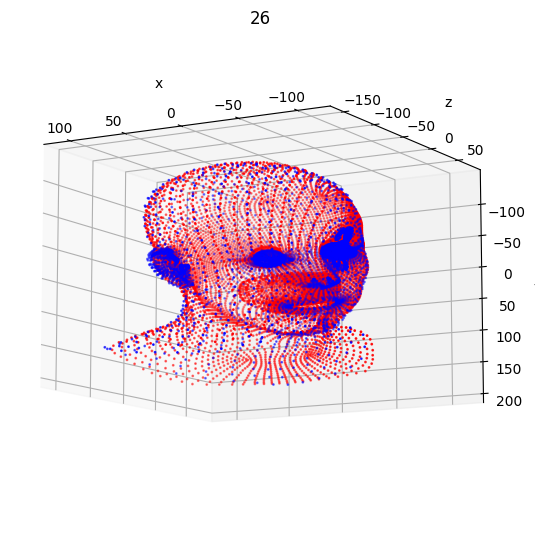

  0%|          | 0/300 [00:00<?, ?it/s]

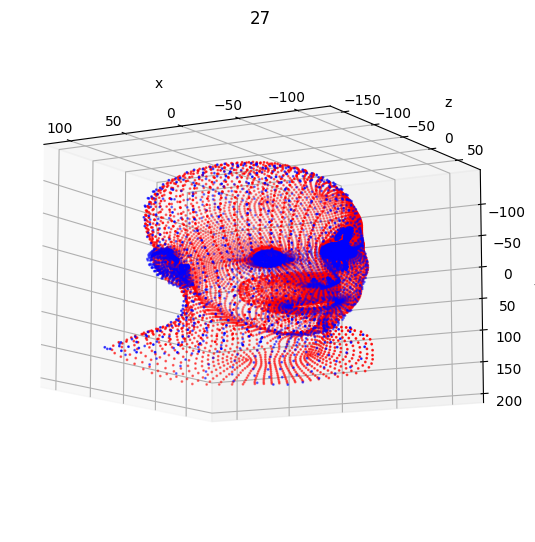

  0%|          | 0/300 [00:00<?, ?it/s]

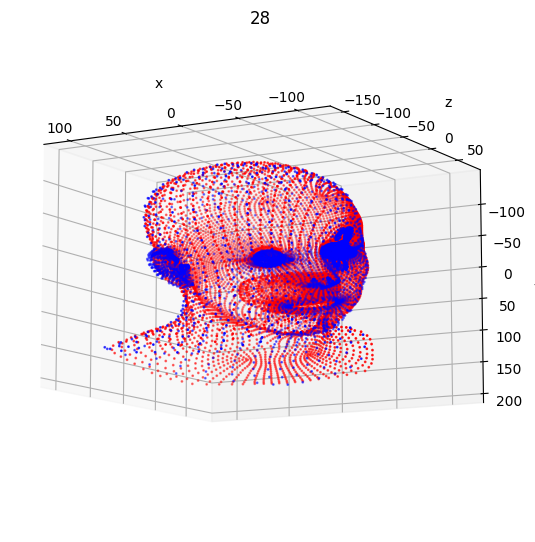

  0%|          | 0/300 [00:00<?, ?it/s]

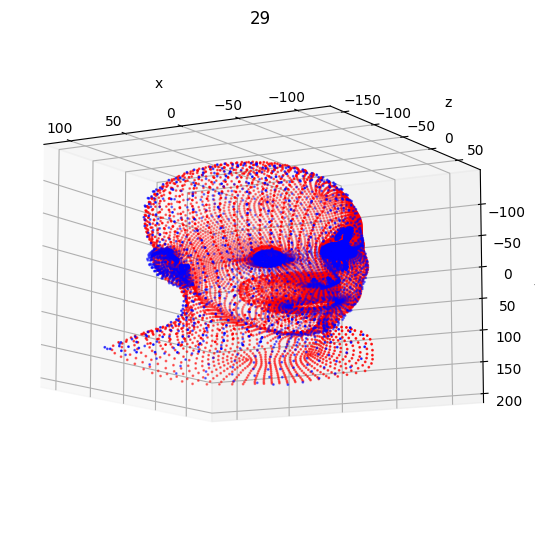

In [36]:
pcl_mask = torch.ones(zero_mesh.verts_padded().size(1)).bool().to(device)
left_nose_mask_idx = [4576, 4578, 4603, 4604, 4605, 4613, 4614, 4615, 4616, 4617, 4618, 4619, 4621, 4625, 4634, 4635, 4636, 4637, 4638, 4639, 4640, 4641, 4642, 4643, 4644, 4645, 4646, 4647, 4648, 4649, 4650, 4651, 4652, 4653, 4654, 4655, 4656, 4657, 4658, 4659, 4660, 4661, 4662, 4663, 4664, 4665, 4666, 4667, 4668, 4669, 4670, 4671, 4672, 4673, 4674, 4675, 4676, 4677, 4678, 4679, 4680, 4681, 4682, 4683, 4684, 4685, 4686, 4687, 4688, 4689, 4690, 4691, 4692, 4693, 4694, 4695, 4696, 4697, 4698, 4699, 4700, 4701, 4702, 4703, 4704, 4705, 4706, 4707, 4708, 4709, 4710, 4711, 4712, 4713, 4714, 4715, 4716, 4717, 4718, 4719, 4720, 4721, 4722, 4723, 4724, 4725, 4726, 4727, 4760, 4787, 4788, 4789, 4790, 4791, 4792, 4793, 4794, 4795, 4796, 4797, 4798, 4799, 4800, 4801, 4802, 4803, 4804, 4805, 4806, 4807, 4808, 4809, 4810, 4811, 4812, 4813, 4814, 4815, 4816, 4817, 4818, 4819, 4820, 4821, 4822, 4823, 4824, 4825, 4826, 4827, 4828, 4829, 4830, 4831, 4832, 4833, 4834, 4835, 4836, 4837, 4872, 4873, 4874, 4875, 4876, 4877, 4878, 4879, 4880, 4881, 4882, 4883, 4884, 4885, 4886, 4887, 4888, 4889, 4890, 4891, 4892, 4893, 4894, 4895, 4896, 4897, 4898, 4899, 4900, 4901, 4902, 4903, 4904, 4905, 4906, 4907, 4908, 4909, 4910, 4911, 4912, 4913, 4914, 4915, 4921, 4922, 4923, 4924, 4925, 4926, 4927, 4928, 4929, 4930, 4931, 4932, 4951, 4952, 4953, 4954, 4955, 4956, 4957, 4958, 4959, 4960, 4961, 4962, 4963, 4964, 4965, 4966, 4967, 4968, 4969, 4970, 4971, 4972, 4973, 4974, 4988, 4989, 4990, 4991, 4992, 4993, 4994, 4995, 4996, 4997, 4998, 4999, 5000, 5001, 5002, 5003, 5004, 5005, 5006, 5007, 5008, 5009, 5010, 5011]
right_nose_mask_idx = [5041, 5043, 5068, 5069, 5070, 5078, 5079, 5080, 5081, 5082, 5083, 5084, 5086, 5090, 5099, 5100, 5101, 5102, 5103, 5104, 5105, 5106, 5107, 5108, 5109, 5110, 5111, 5112, 5113, 5114, 5115, 5116, 5117, 5118, 5119, 5120, 5121, 5122, 5123, 5124, 5125, 5126, 5127, 5128, 5129, 5130, 5131, 5132, 5133, 5134, 5135, 5136, 5137, 5138, 5139, 5140, 5141, 5142, 5143, 5144, 5145, 5146, 5147, 5148, 5149, 5150, 5151, 5152, 5153, 5154, 5155, 5156, 5157, 5158, 5159, 5160, 5161, 5162, 5163, 5164, 5165, 5166, 5167, 5168, 5169, 5170, 5171, 5172, 5173, 5174, 5175, 5176, 5177, 5178, 5179, 5180, 5181, 5182, 5183, 5184, 5185, 5186, 5187, 5188, 5189, 5190, 5191, 5192, 5225, 5251, 5252, 5253, 5254, 5255, 5256, 5257, 5258, 5259, 5260, 5261, 5262, 5263, 5264, 5265, 5266, 5267, 5268, 5269, 5270, 5271, 5272, 5273, 5274, 5275, 5276, 5277, 5278, 5279, 5280, 5281, 5282, 5283, 5284, 5285, 5286, 5287, 5288, 5289, 5290, 5291, 5292, 5293, 5294, 5295, 5296, 5297, 5298, 5299, 5300, 5301, 5330, 5331, 5332, 5333, 5334, 5335, 5336, 5337, 5338, 5339, 5340, 5341, 5342, 5343, 5344, 5345, 5346, 5347, 5348, 5349, 5350, 5351, 5352, 5353, 5354, 5355, 5356, 5357, 5358, 5359, 5360, 5361, 5362, 5363, 5364, 5365, 5366, 5367, 5368, 5369, 5370, 5371, 5372, 5373, 5378, 5379, 5380, 5381, 5382, 5383, 5384, 5385, 5386, 5387, 5388, 5389, 5405, 5406, 5407, 5408, 5409, 5410, 5411, 5412, 5413, 5414, 5415, 5416, 5417, 5418, 5419, 5420, 5421, 5422, 5423, 5424, 5425, 5426, 5427, 5428, 5442, 5443, 5444, 5445, 5446, 5447, 5448, 5449, 5450, 5451, 5452, 5453, 5454, 5455, 5456, 5457, 5458, 5459, 5460, 5461, 5462, 5463, 5464, 5465]
pcl_mask[11248:13294] = False # mouth
pcl_mask[13294:13678] = False
pcl_mask[13678:14062] = False
for idx in left_nose_mask_idx:
    pcl_mask[idx] = False
for idx in right_nose_mask_idx:
    pcl_mask[idx] = False
hack_face_mask = torch.ones(faces.size(0)).bool().to(device)
for i in range(faces.size(0)):
    pts_idx = faces[i]
    if (11248<=pts_idx[0]<13294) and (11248<=pts_idx[1]<13294) and (11248<=pts_idx[2]<13294):
        hack_face_mask[i] = False
    elif (13294<=pts_idx[0]<13678) and (13294<=pts_idx[1]<13678) and (13294<=pts_idx[2]<13678):
        hack_face_mask[i] = False
    elif (13678<=pts_idx[0]<14062) and (13678<=pts_idx[1]<14062) and (13678<=pts_idx[2]<14062):
        hack_face_mask[i] = False
    elif (pts_idx[0].item() in left_nose_mask_idx) and (pts_idx[1].item() in left_nose_mask_idx) and (pts_idx[2].item() in left_nose_mask_idx):
        hack_face_mask[i] = False
    elif (pts_idx[0].item() in right_nose_mask_idx) and (pts_idx[1].item() in right_nose_mask_idx) and (pts_idx[2].item() in right_nose_mask_idx):
        hack_face_mask[i] = False

def eye_dis(landmarks):
    # left eye:  [38,42], [39,41] - 1
    # right eye: [44,48], [45,47] -1
    eye_up = landmarks[[37, 38, 43, 44], :]
    eye_bottom = landmarks[[41, 40, 47, 46], :]
    dis = torch.norm(eye_up - eye_bottom, dim = 1) 
    return dis

def eyed_loss(predicted_landmarks, landmarks_gt):
    pred_eyed = eye_dis(predicted_landmarks)
    gt_eyed = eye_dis(landmarks_gt)
    loss = (pred_eyed - gt_eyed).abs().mean()
    return loss

def lip_dis(landmarks):
    # up inner lip:  [62, 63, 64] - 1
    # down innder lip: [68, 67, 66] -1
    lip_up = landmarks[[61, 62, 63], :]
    lip_down = landmarks[[67, 66, 65], :]
    dis = torch.norm(lip_up - lip_down, dim = 1) 
    return dis

def lipd_loss(predicted_landmarks, landmarks_gt):
    pred_lipd = lip_dis(predicted_landmarks)
    gt_lipd = lip_dis(landmarks_gt)
    loss = (pred_lipd - gt_lipd).abs().mean()
    return loss
def face_vertices(vertices, faces):
  """
  :param vertices: [batch size, number of vertices, x]
  :param faces: [batch size, number of faces, 3]
  :return: [batch size, number of faces, 3, 3]
  """
  assert (vertices.ndimension() == 3)
  assert (faces.ndimension() == 3)
  assert (vertices.shape[0] == faces.shape[0])
  #assert (vertices.shape[2] == 3)
  assert (faces.shape[2] == 3)

  bs, nv = vertices.shape[:2]
  bs, nf = faces.shape[:2]
  device = vertices.device
  faces = faces + (torch.arange(bs, dtype=torch.int32).to(device) * nv)[:, None, None]
  vertices = vertices.reshape((bs * nv, -1))
  # pytorch only supports long and byte tensors for indexing
  return vertices[faces.long()]
def get_ellipse_attr(points):
    center = torch.mean(points, dim=0).view(1,3)
    #vectors = points - center
    cov = torch.cov(points.T)  
    U, _, _= torch.svd(cov)
    return center, U
def nose_ellipse_loss(predicted_pts, gt_pts):
    pred = predicted_pts.view(-1, 3)
    gt = gt_pts.view(-1,3).detach()
    c1, u1 = get_ellipse_attr(pred)
    c2, u2 = get_ellipse_attr(gt_pts)
    return torch.nn.functional.l1_loss(u1, u2) + torch.nn.functional.l1_loss(c1, c2)
    
ldm_weight = torch.ones((68,)).to(device)
ldm_weight[5:7] = 2
ldm_weight[10:12] = 2
# nose points
ldm_weight[27:36] = 1.5
ldm_weight[30] = 6
ldm_weight[31] = 6
ldm_weight[35] = 6
# inner mouth
ldm_weight[60:68] = 1.5
ldm_weight[48:60] = 1.5
ldm_weight[48] = 3
ldm_weight[54] = 3

flnci = torch.LongTensor([1613, 1616, 1628, 1629, 2233, 2241, 2753, 2756, 2797, 2798, 2909, 2910, 2911]).to(device)
frnci = torch.LongTensor([480, 486, 487, 759, 766, 767, 1626, 1639, 1806, 1807, 1808, 3810, 3813, 3845]).to(device)
hlnci = torch.LongTensor([4563, 4564, 4575, 4579, 4585, 4586, 4598, 4599, 4601, 4608, 4611, 4612, 4620, 4759, 4778, 4779, 4780, 4783, 4916, 4933, 4950, 4975, 4987, 5012]).to(device)
hrnci = torch.LongTensor([5028, 5029, 5040, 5044, 5050, 5051, 5063, 5064, 5066, 5073, 5076, 5077, 5085, 5224, 5242, 5243, 5244, 5247, 5374, 5390, 5404, 5429, 5441, 5466]).to(device)

fln = torch.index_select(flame_mesh.verts_padded().detach()[0], 0, flnci)
frn = torch.index_select(flame_mesh.verts_padded().detach()[0], 0, frnci)

for epoch in range(num_epoch):
  loop = tqdm(range(num_iter))
  for _iter in loop:
    optimizer.zero_grad()
    # (B,N,3)
    
    offset = hack(theta, tau, alpha, bsw, T=S(beta), E=E(), P=P())["T_transformed"][0]
    deformed_mesh = zero_mesh.detach().offset_verts(offset)
    deformed_mesh.scale_verts_(scale)
    op = offset_p.repeat(offset.shape[0], 1)
    deformed_mesh.offset_verts_(op)

    deformed_pcl = Pointclouds(deformed_mesh.verts_padded()[:, pcl_mask])
    
    deformed_verts = deformed_mesh.verts_padded()
    target_verts = flame_mesh.verts_padded().detach()

    # verts loss, target_verts have more verts
    # knn = knn_points(target_verts, deformed_verts)
    # nearest_verts = knn_gather(deformed_verts, knn.idx)[:,:,0] # TODO
  
    # sample_trg = sample_points_from_meshes(flame_mesh, 4000)
    # sample_src = sample_points_from_meshes(deformed_mesh, 4000)
    # loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)
    
    # and (b) the edge length of the predicted mesh
    loss_edge = mesh_edge_loss(deformed_mesh)
    
    # mesh normal consistency
    loss_normal = mesh_normal_consistency(deformed_mesh)
    
    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(deformed_mesh, method="uniform")
      
    # (B,N,3)
    # distance = torch.sum((target_verts - nearest_verts).abs(), dim = 2)
    # mask = (distance<distance_judge).float().detach()
    # ldm
    deformed_ldms = torch.index_select(deformed_verts[0], 0, hack_ldms_idx) # (n,3)
    loss_eye = eyed_loss(deformed_ldms, flame_ldms[0])
    loss_lip = lipd_loss(deformed_ldms, flame_ldms[0])
    loss_ldm = (torch.norm(deformed_ldms - flame_ldms[0], dim = 1, p = 1) * ldm_weight).mean()
    # loss_verts = (mask * distance).sum() / (mask.sum() + 1e-7)
    deformed_mesh_without_socket = Meshes(faces = faces[hack_face_mask].unsqueeze(0), verts=deformed_mesh.verts_padded())
    
    loss_mf = pytorch3d.loss.point_mesh_face_distance(flame_mesh_no_eye.detach(), deformed_pcl)
    loss_mf += 0.2*pytorch3d.loss.point_mesh_face_distance(deformed_mesh_without_socket, flame_pcl_no_eye.detach())
    #bsw_valid = torch.nn.functional.relu(bsw)
    hln = torch.index_select(deformed_mesh.verts_padded()[0], 0, hlnci)
    hrn = torch.index_select(deformed_mesh.verts_padded()[0], 0, hrnci)
    loss_nose = nose_ellipse_loss(hln, fln) + nose_ellipse_loss(hrn, frn)
    loss_norm = torch.norm(bsw, 2) * 1e-4 + torch.norm(beta, 2) * 1e-4
    loss = loss_nose * 10 + loss_ldm + loss_laplacian*0.1 + loss_norm  + loss_mf + loss_edge * 0.1 + loss_eye*0.1 + loss_lip*0.1
    
   
    loop.set_description(f"[Loss: {loss:.6f}] [ldm: {loss_ldm:.6f}] ")
    loss.backward()
    optimizer.step()
  plot_mesh2(flame_mesh, deformed_mesh, f"{epoch}")

In [37]:
#beta, theta, scale, offset_p, bsw

pytorch3d.io.save_obj("assets/tmp.obj",
                      verts= deformed_mesh.detach().verts_padded().clone()[0],
                      faces = deformed_mesh.detach().faces_padded().clone()[0])

In [38]:


def barycentric_coords(a, b, c, q):
  # a(n, 3)
  v1 = b-a
  v2 = c-a
  n = torch.cross(v1, v2)
  n_dot_n = torch.sum(n*n, dim=-1)
  w = q - a
  gamma = torch.sum(torch.cross(v1, w)*n, dim=-1)/n_dot_n
  beta = torch.sum(torch.cross(w, v2)*n, dim=-1)/n_dot_n
  alpha = 1.0-beta-gamma
  return torch.stack([alpha, beta, gamma], dim = 1)
def render_test(vertices, faces, uv_vertices, uv_faces, uv_image, image_size = 512):
  # OK
  # vertices (B, V, 3)
  # faces (B, F, 3)
  fixed_vertices = vertices.clone()
  fixed_vertices[..., 0] = -2*fixed_vertices[..., 0] + 1
  fixed_vertices[..., 1] = 2*fixed_vertices[..., 1] - 1
  fixed_vertices[..., 2] = -fixed_vertices[..., 2] + 10
  meshes_screen = Meshes(verts=fixed_vertices.float(), faces=faces.long())
  pix_to_face, zbuf, bary_coords, dists = rasterize_meshes(
      meshes_screen,
      image_size=image_size,
      blur_radius=0,
      faces_per_pixel=1,
      bin_size=None,
      max_faces_per_bin=None
  )
  vismask = (pix_to_face > -1).float()
  mask = pix_to_face == -1
  # pix_to_face: (N, image_size, image_size, 1)
  pix_to_face = pix_to_face.clone()
  pix_to_face[mask] = 0
  # torch.Size([262144, 3])
  idx = pix_to_face.flatten()

  pixel_face_idx = torch.index_select(faces.view(-1,3),0, idx) #(n, 3)

  uv_face_idx = torch.index_select(uv_faces.view(-1,3), 0, idx)

  p1 = torch.index_select(uv_vertices[0], 0, uv_face_idx[:, 0]) #(n,2)
  p2 = torch.index_select(uv_vertices[0], 0, uv_face_idx[:, 1]) #(n,2)
  p3 = torch.index_select(uv_vertices[0], 0, uv_face_idx[:, 2]) #(n,2)
  p = torch.stack([p1, p2, p3], dim = 1) # (b,3,2)
  p_interp = (p * bary_coords.view(-1,3,1)).sum(1)
  grid = p_interp.view(-1, image_size, image_size, 2)
  grid = grid * 2 - 1
  grid[...,1] = -grid[..., 1]

  output = torch.nn.functional.grid_sample(uv_image.permute(0,3,1,2),
                                           grid,
                                           mode='bilinear',
                                           padding_mode="border",
                                           align_corners=False)

  return output


Render HACK with FLAME Texture. Until now, we haven't converted HACK to FLAME, just use FLAME Texture using knn to get it's corresponding texture color.

In [39]:
scaled_verts = deformed_mesh.detach().verts_padded().clone()
flame_scaled_verts = flame_mesh.verts_padded().clone()

Convert HACK's UV coordinate to the nearest FLAME's UV coordinate, then we can use these coordinates to render without knn process, because we have changed the UV coordinate itself.

In [40]:
def render_train(mesh, faces_uv, coords_uv, uv_image, angle, image_size = 512):
  # OK
  # vertices (B, V, 3)
  # faces (B, F, 3)
  fixed_vertices = mesh.verts_padded().clone()
  scale_ = max(fixed_vertices[..., 0].max() - fixed_vertices[..., 0].min(), fixed_vertices[..., 1].max() - fixed_vertices[..., 1].min())
  fixed_vertices[..., :2] /= scale_
  fixed_vertices[..., :2] += 0.5
  fixed_vertices[..., 2] -= fixed_vertices[..., 2].min()
  fixed_vertices[..., 2] = fixed_vertices[..., 2] / fixed_vertices[..., 2].max()
  fixed_vertices[..., 0] = -2*fixed_vertices[..., 0] + 1
  fixed_vertices[..., 1] = 2*fixed_vertices[..., 1] - 1
  fixed_vertices[..., 2] = -fixed_vertices[..., 2]
  M = roma.rotvec_to_rotmat(angle)

  fixed_vertices = fixed_vertices@M
  fixed_vertices[..., 2] += 10
  meshes_screen = Meshes(verts=fixed_vertices.float(), faces=mesh.faces_padded().clone())

  pix_to_face, zbuf, bary_coords, dists = rasterize_meshes(
      meshes_screen,
      image_size=image_size,
      blur_radius=0,
      faces_per_pixel=1,
      bin_size=None,
      max_faces_per_bin=None
  )

  vismask = (pix_to_face > -1).float()
  mask = pix_to_face == -1
  # pix_to_face: (N, image_size, image_size, 1)
  pix_to_face = pix_to_face.clone()
  pix_to_face[mask] = 0
  # torch.Size([262144, 3])
  idx = pix_to_face.flatten()

  #pixel_face_idx = torch.index_select(faces.view(-1,3),0, idx) #(n, 3)
  uv_face_idx = torch.index_select(faces_uv.view(-1,3), 0, idx)
  # faces_uv (b, n, 3, 2)

  p1 = torch.index_select(coords_uv[0], 0, uv_face_idx[:,0])
  p2 = torch.index_select(coords_uv[0], 0, uv_face_idx[:,1])
  p3 = torch.index_select(coords_uv[0], 0, uv_face_idx[:,2])

  p = torch.stack([p1, p2, p3], dim = 1)
  p_interp = (p * bary_coords.view(-1,3,1)).sum(1)
  grid = p_interp.view(-1, image_size, image_size, 2)
  grid = grid * 2 - 1
  grid[...,1] = -grid[..., 1]

  output = torch.nn.functional.grid_sample(uv_image.permute(0,3,1,2),
                                           grid,
                                           mode='bilinear',
                                           padding_mode="border",
                                           align_corners=True)

  return output, vismask.view(1, 1, image_size, image_size)
def render_train2(mesh, faces_coords_uv, uv_image, angle, image_size = 512, ldm_world = None):
    # OK
    # vertices (B, V, 3)
    # faces (B, F, 3)
    fixed_vertices = mesh.verts_padded().clone()
    scale_ = max(fixed_vertices[..., 0].max() - fixed_vertices[..., 0].min(), fixed_vertices[..., 1].max() - fixed_vertices[..., 1].min())
    fixed_vertices[..., :2] /= scale_
    fixed_vertices[..., :2] += 0.5
    z_offset = fixed_vertices[..., 2].min()
    fixed_vertices[..., 2] -= z_offset
    z_max = fixed_vertices[..., 2].max()
    fixed_vertices[..., 2] = fixed_vertices[..., 2] / z_max
    fixed_vertices[..., 0] = -2*fixed_vertices[..., 0] + 1
    fixed_vertices[..., 1] = 2*fixed_vertices[..., 1] - 1
    fixed_vertices[..., 2] = -fixed_vertices[..., 2]
    M = roma.rotvec_to_rotmat(angle)
    
    fixed_vertices = fixed_vertices@M
    fixed_vertices[..., 2] += 10
    out_ldm = None
    if ldm_world is not None:
        ldm_ = ldm_world.clone().view(1,-1,3)
        ldm_[..., :2] /= scale_
        ldm_[..., :2] += 0.5
        ldm_[..., 2] -= z_offset
        ldm_[..., 2] /= z_max
        ldm_[..., 0] = -2 * ldm_[..., 0] + 1
        ldm_[..., 1] = 2 * ldm_[..., 1] - 1
        ldm_[..., 2] = -ldm_[..., 2]
        ldm_ = ldm_ @ M
        out_ldm = ldm_[..., :2]
        out_ldm = out_ldm + 1
        out_ldm = out_ldm / 2
        out_ldm[..., 1] = 1 - out_ldm[..., 1]
        out_ldm[..., 0] = 1 - out_ldm[..., 0]
        out_ldm = out_ldm * image_size
    meshes_screen = Meshes(verts=fixed_vertices.float(), faces=mesh.faces_padded().clone())
    
    pix_to_face, zbuf, bary_coords, dists = rasterize_meshes(
      meshes_screen,
      image_size=image_size,
      blur_radius=0,
      faces_per_pixel=1,
      bin_size=None,
      max_faces_per_bin=None
    )
    
    vismask = (pix_to_face > -1).float()
    mask = pix_to_face == -1
    # pix_to_face: (N, image_size, image_size, 1)
    pix_to_face = pix_to_face.clone()
    pix_to_face[mask] = 0
    # torch.Size([262144, 3])
    idx = pix_to_face.flatten()
    
    #pixel_face_idx = torch.index_select(faces.view(-1,3),0, idx) #(n, 3)
    #uv_face_idx = torch.index_select(faces_uv.view(-1,3), 0, idx)
    # faces_uv (b, n, 3, 2)
    
    # p1 = torch.index_select(coords_uv[0], 0, uv_face_idx[:,0])
    # p2 = torch.index_select(coords_uv[0], 0, uv_face_idx[:,1])
    # p3 = torch.index_select(coords_uv[0], 0, uv_face_idx[:,2])
    p = torch.index_select(faces_coords_uv[0], 0, idx)
    p_interp = (p * bary_coords.view(-1,3,1)).sum(1)
    grid = p_interp.view(-1, image_size, image_size, 2)
    grid = grid * 2 - 1
    grid[...,1] = -grid[..., 1]
    
    output = torch.nn.functional.grid_sample(uv_image.permute(0,3,1,2),
                                           grid,
                                           mode='bilinear',
                                           padding_mode="border",
                                           align_corners=True)

    return output, vismask.view(1, 1, image_size, image_size), out_ldm

In [26]:
from PIL import Image
import roma
import torchvision
img = Image.open("assets/test_uv.png")
convert_tensor = torchvision.transforms.ToTensor()
uv_map = convert_tensor(img).unsqueeze(0).to(device).permute(0,2,3,1)
import torch.nn as nn

In [41]:
from torch.nn.utils import spectral_norm
def to_voxel(verts):
    point_cloud = verts.clone()
    scale = point_cloud[..., 0].max() - point_cloud[..., 0].min()
    scale = max(scale, point_cloud[..., 1].max() - point_cloud[..., 1].min())
    scale = max(scale, point_cloud[..., 2].max() - point_cloud[..., 2].min())
    point_cloud[..., 0] -= point_cloud[..., 0].min()
    point_cloud[..., 1] -= point_cloud[..., 1].min()
    point_cloud[..., 2] -= point_cloud[..., 2].min()
    # point_cloud = point_cloud / scale
    resolution = 64
    voxel_size = scale / resolution
    voxel_grid = torch.zeros((resolution, resolution, resolution), dtype=torch.float32).to(device)
    indices = (point_cloud / voxel_size).long()
    indices = torch.clamp(indices, min=0, max=resolution - 1)
    voxel_grid[indices[:, 0], indices[:, 1], indices[:, 2]] = 1.0
    voxel_grid = voxel_grid.unsqueeze(0).unsqueeze(0)
    #voxel_grid = torch.nn.functional.pad(voxel_grid, (1, 1, 1, 1, 1, 1), mode='constant', value=0)
    return voxel_grid

class UVMapper(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            spectral_norm(nn.Linear(3, 1024)),
            nn.LeakyReLU(),
            spectral_norm(nn.Linear(1024, 1024)),
            nn.LeakyReLU(),
            # spectral_norm(nn.Linear(1024, 1024)),
            # nn.LeakyReLU(),
            # spectral_norm(nn.Linear(1024, 1024)),
            # nn.LeakyReLU(),
            # spectral_norm(nn.Linear(1024, 1024)),
            # nn.LeakyReLU(),
            spectral_norm(nn.Linear(1024,2))
            # nn.Linear(3, 1024),
            # nn.LeakyReLU(),
            # nn.Linear(1024, 1024),
            # nn.LeakyReLU(),
            # nn.Linear(1024, 1024),
            # nn.LeakyReLU(),
            # nn.Linear(1024,2)
        )
    def forward(self,x):
        return self.net(x)
class VoxelEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=4, stride = 2, padding=1),
            nn.InstanceNorm3d(32),
            nn.LeakyReLU(),
            nn.Conv3d(32, 64, kernel_size=4, stride = 2, padding=1),
            nn.InstanceNorm3d(64),
            nn.LeakyReLU(),
            nn.Conv3d(64, 128, kernel_size=4, stride = 2, padding=1),
            nn.InstanceNorm3d(128),
            nn.LeakyReLU(),
            nn.Conv3d(128, 256, kernel_size=4, stride = 2, padding=1),
            nn.InstanceNorm3d(256),
            nn.LeakyReLU(),
            nn.Conv3d(256, 512, kernel_size=4, stride = 1, padding=0),
            # nn.InstanceNorm3d(512),
            nn.LeakyReLU(),
            nn.Conv3d(512, 256, kernel_size=1, stride = 1, padding=0),
            # nn.InstanceNorm3d(256),
            nn.LeakyReLU()
        )
    def forward(self,x):
        return self.net(x).view(-1,256)
def show_voxel(voxel):
    v = voxel.clone()[0,0].detach().cpu().numpy()
    #colors = np.empty(v.shape, dtype=object)
    #colors[v] = 'red'
    ax = plt.figure().add_subplot(projection='3d')
    ax.voxels(v, facecolors='red', edgecolor='k')
    plt.show()

# deformed_voxel = to_voxel(deformed_mesh.verts_padded()[0].clone()).detach()
# flame_voxel = to_voxel(flame_mesh.verts_padded()[0].clone()).detach()
# voxel_encoder = VoxelEncoder().to(device)
uv_mapper = UVMapper().to(device)

# voxel_encoder.train()
uv_mapper.train()
#optimizer = torch.optim.SGD(uv_mapper.parameters(), lr = 0.01, weight_decay = 5e-4)

#optimizer = torch.optim.AdamW(uv_mapper.parameters(), lr = 1e-3, amsgrad=True)
optimizer = torch.optim.AdamW([
    # {
    #     "params": [beta, theta, scale, offset_p, bsw, alpha, tau]
    # },
    {
        "params": uv_mapper.parameters()
    },
], lr=1e-3, amsgrad=True) # , 

  0%|          | 0/10000 [00:00<?, ?it/s]

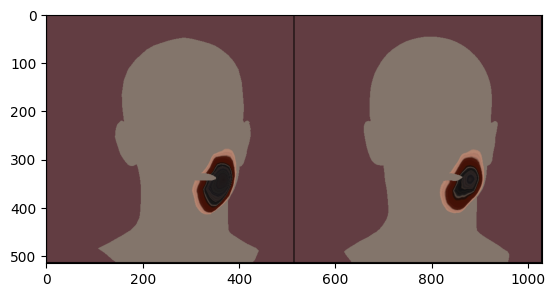

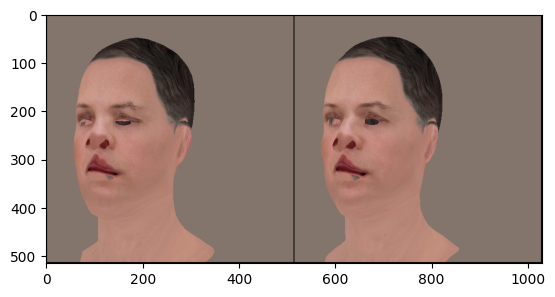

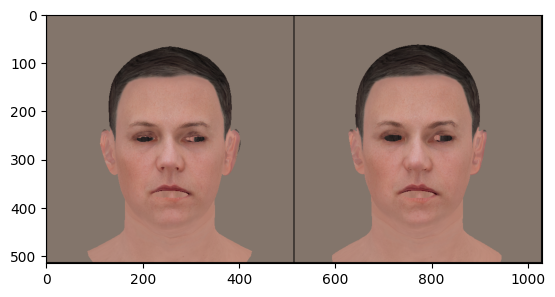

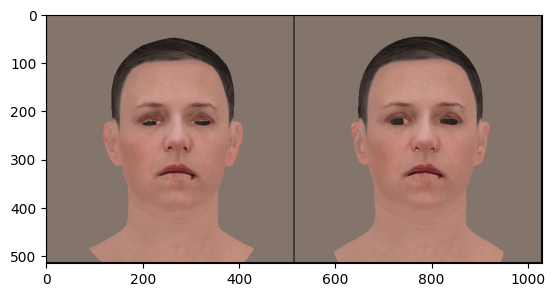

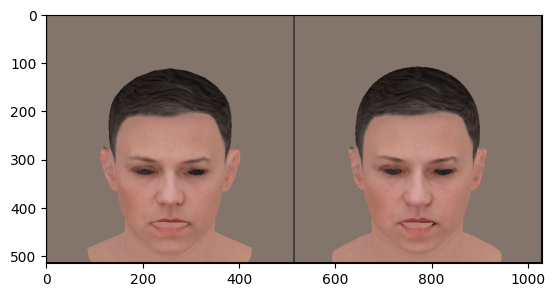

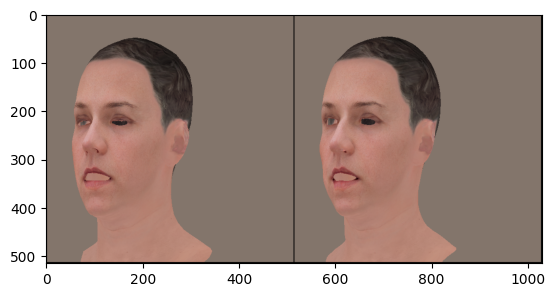

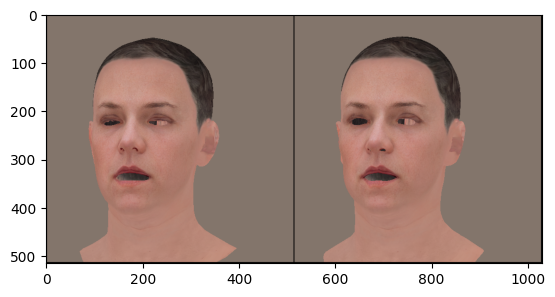

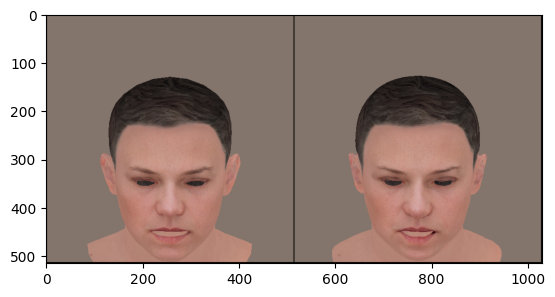

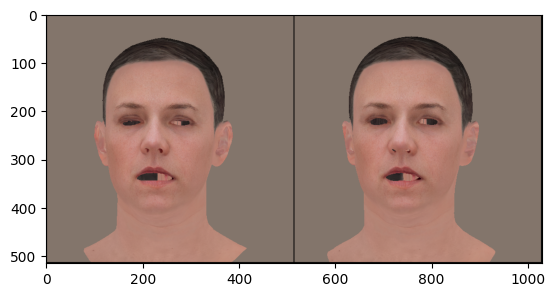

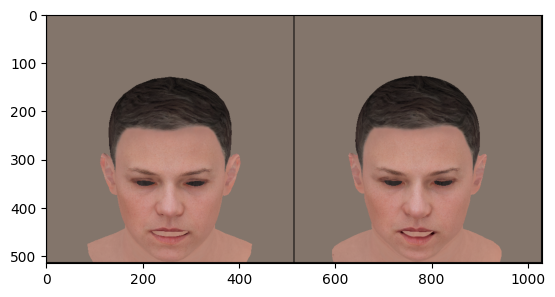

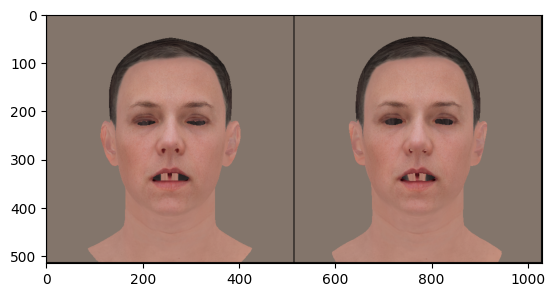

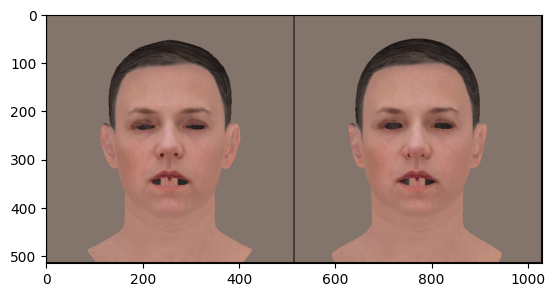

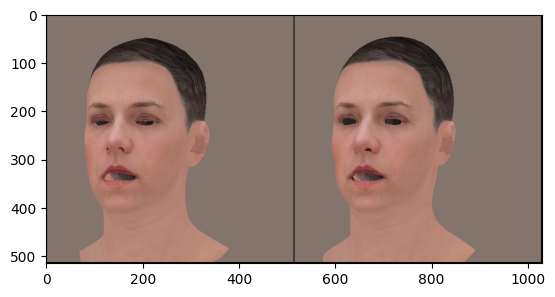

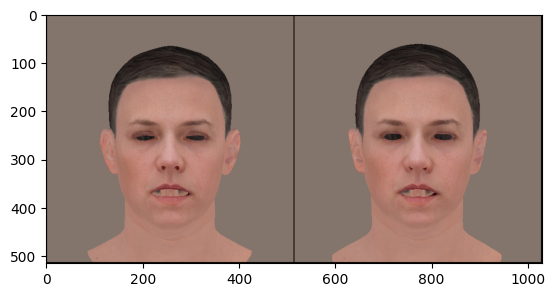

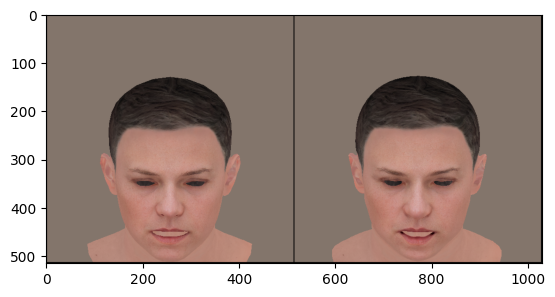

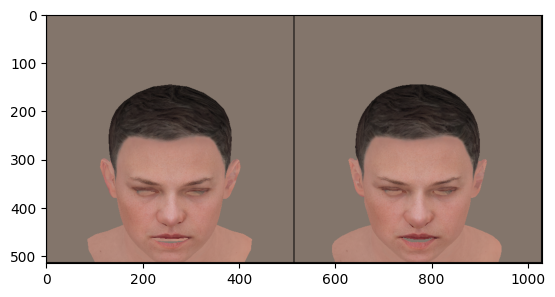

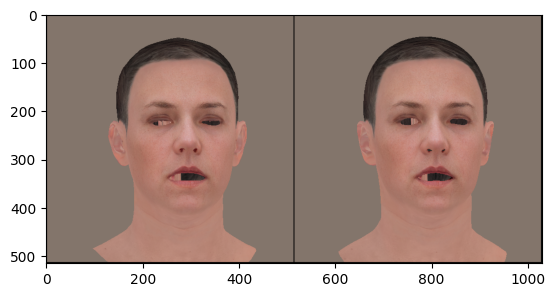

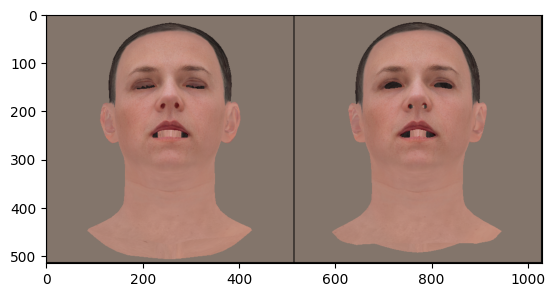

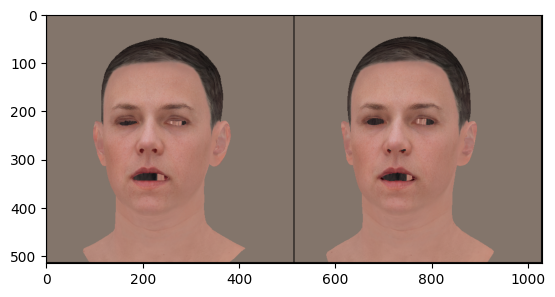

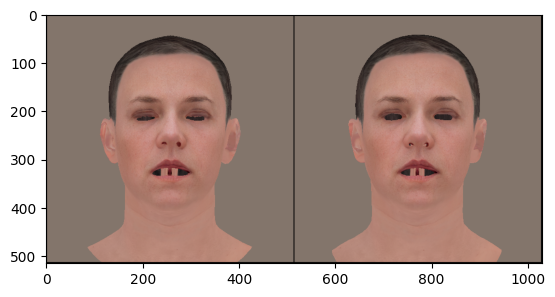

In [42]:

flame_face_verts = face_vertices(flame_mesh.verts_padded().clone(), flame_mesh.faces_padded().clone())
flame_face_uv_verts = face_vertices(flame_vts.clone(), flame_fvts.clone())
bar = tqdm(range(10000))


def calculate_gradient_penalty(net, x):
    inputs = x + torch.Tensor(x.size(0), 3).uniform_(-5e-3,5e-3).to(device)
    inputs.requires_grad = True

    pred = net(x)
    
    gradients = torch.autograd.grad(outputs=pred, inputs=inputs,
                               grad_outputs=torch.ones(pred.size()).to(device),
                               create_graph=True, retain_graph=True, allow_unused=True)[0]

    grad_penalty = ((torch.norm(inputs, 2, dim = 1) - 1) ** 2).mean() * 1e-4

    return grad_penalty
def get_valid_mask(sample_uv_verts):
    mask = ((sample_uv_verts[..., 0] > 1)) | ((sample_uv_verts[..., 1] > 1))
    mask = mask | ((sample_uv_verts[..., 0] >= 0.12) & (sample_uv_verts[..., 0] <= 0.18) & (sample_uv_verts[..., 1] >= 0.928) & (sample_uv_verts[..., 1] <= 0.98))
    mask = mask | ((sample_uv_verts[..., 0] >= 0.83) & (sample_uv_verts[..., 0] <= 0.89) & (sample_uv_verts[..., 1] >= 0.928) & (sample_uv_verts[..., 1] <= 0.98))
    mask = mask | (sample_uv_verts[..., 0] < 0.01) | (sample_uv_verts[..., 0] > 0.99)
    mask = ~mask
    return mask[..., 0] | mask[..., 1] | mask[..., 2] 
flame_face_valid_mask = get_valid_mask(flame_face_uv_verts.view(-1,3,2))

all_valid_verts_tmp = (flame_face_verts.view(-1,3,3)[flame_face_valid_mask]).view(-1,3)
all_valid_uvs_tmp = (flame_face_uv_verts.view(-1,3,2)[flame_face_valid_mask]).view(-1,2)

all_valid_verts, uidx = torch.unique(all_valid_verts_tmp, dim = 0, return_inverse = True)
all_valid_uvs = torch.zeros(all_valid_verts.size(0), 2).to(device)
for i in range(all_valid_verts.size(0)):
    all_valid_uvs[uidx[i]] = all_valid_uvs_tmp[i]

flame_valid_mesh = Meshes(verts = flame_vs, faces = flame_fvs[:, flame_face_valid_mask]).to(device)
# torch.Size([1, 5023, 3]) tensor(7597, device='cuda:0') torch.Size([1, 7597, 3])

hack_valid_mesh = deformed_mesh_without_socket.detach().clone()
hack_valid_faces_verts = face_vertices(hack_valid_mesh.verts_padded().clone(), hack_valid_mesh.faces_padded().clone())
nose_ldm_world = torch.index_select(deformed_mesh.detach().verts_padded()[0], 0, hack_ldms_idx[33]).view(1,3)
# with torch.no_grad():
    
for iter in bar:
    optimizer.zero_grad()
    # hack_valid_mesh = deformed_mesh_without_socket
    # hack_valid_faces_verts = face_vertices(hack_valid_mesh.verts_padded(), hack_valid_mesh.faces_padded())
    # nose_ldm_world = torch.index_select(deformed_mesh.verts_padded()[0], 0, hack_ldms_idx[33]).view(1,3)
    # code = voxel_encoder(flame_voxel)
    uv_coord = uv_mapper(all_valid_verts_tmp).view(-1,2)
    sample_idx  = torch.randperm(uv_coord.size(0))[:6000]
    
    sample_verts = all_valid_verts_tmp[sample_idx]
    sample_uv_verts = all_valid_uvs_tmp[sample_idx]
    sample_pred_uv = uv_coord[sample_idx]
    # train with valid region
    # mask = get_valid_mask(sample_uv_verts)
    # valid_sample_verts = sample_verts[mask]
    # valid_sample_uv_verts = sample_uv_verts[mask]

    # if(valid_sample_verts.size(0) == 0) :
    #     continue
    # input_feat = torch.cat([valid_sample_verts, code.repeat(valid_sample_verts.size(0), 1)], dim = 1)
    # uv_coord = uv_mapper(input_feat).view(-1,2)

    # gp
    # gradient_penalty = calculate_gradient_penalty(uv_mapper, valid_sample_verts)
    # gradient_penalty.backward()

    # smoothness
    #torch.cdist()
    # dist_verts = torch.norm(valid_sample_verts.view(1,-1,3) - all_valid_verts.view(-1,1,3), p=1, dim = 2)
    # dist_uvs = torch.norm(valid_sample_uv_verts.view(1,-1,2) - all_valid_uvs.view(-1,1,2), p=1, dim = 2)
    # msk = (dist_verts < 5).detach()
    # loss_smooth = dist_uvs[msk].mean()
    _, idx, _ = pytorch3d.ops.ball_query(sample_verts.view(1,-1,3), all_valid_verts.view(1,-1,3), K=10, radius = 8)
    idx = idx.view(-1, 10)
    idx_mask = (idx >=0)
    dist = (sample_uv_verts.view(-1,1,2) - all_valid_uvs[idx]).abs()
    loss_smooth = dist[idx_mask].mean()
    # idx (N, p1, K)

    # render loss
    # uv_coord_all = uv_mapper(all_valid_verts_tmp.view(-1, 3)).view(1, -1, 3,2)
    angle = torch.zeros(1, 3).to(device)
    if random.randint(0, 1):
        angle[0,1] = (torch.rand(1) * 2 - 1) * torch.pi / 4.
    else:
        angle[0,0] = (torch.rand(1) * 2 - 1) * torch.pi / 4.
    flame_image_pred, vm1, _ = render_train2(flame_valid_mesh.detach(), uv_coord.view(1, -1, 3, 2), uv_map, angle, image_size = 512) 
    flame_image_gt, vm2, _ = render_train2(flame_valid_mesh.detach(), all_valid_uvs_tmp.view(1,-1,3,2), uv_map, angle, image_size = 512) 
    uv_coord_hack    = uv_mapper(hack_valid_faces_verts.view(-1,3).detach()).view(1, -1, 3,2)

    hack_image, vm3, nose_pixel  = render_train2(hack_valid_mesh.detach(), uv_coord_hack, uv_map, angle, image_size = 512, ldm_world = nose_ldm_world.detach()) 
    
    loss_render_flame = ((flame_image_pred - flame_image_gt).abs() * vm1 * vm2).sum() / (vm1 * vm2).sum()
    
    loss_render_hack = ((hack_image - flame_image_gt).abs() * vm3 * vm2).sum() / (vm3 * vm2).sum()
   
    xmin = int(nose_pixel[0,0,0].item() - 35)
    xmax = int(nose_pixel[0,0,0].item() + 35)
    ymin = int(nose_pixel[0,0,1].item() - 25)
    ymax = int(nose_pixel[0,0,1].item() + 25)
    
    loss_render_hack_nose = ((hack_image[..., ymin:ymax, xmin:xmax] - flame_image_gt[..., ymin:ymax, xmin:xmax]).abs()).mean()
    
    #################################
    ## finetune 
    # offset = hack(theta, tau, alpha, bsw, T=S(beta), E=E(), P=P())["T_transformed"][0]
    # deformed_mesh = zero_mesh.detach().offset_verts(offset)
    # deformed_mesh.scale_verts_(scale)
    # op = offset_p.repeat(offset.shape[0], 1)
    # deformed_mesh.offset_verts_(op)
    # deformed_pcl = Pointclouds(deformed_mesh.verts_padded()[:, pcl_mask])
    # deformed_verts = deformed_mesh.verts_padded()
    # target_verts = flame_mesh.verts_padded().detach()

    # # verts loss, target_verts have more verts
    # knn = knn_points(target_verts, deformed_verts)
    # nearest_verts = knn_gather(deformed_verts, knn.idx)[:,:,0] # TODO
  
    # # sample_trg = sample_points_from_meshes(flame_mesh, 4000)
    # # sample_src = sample_points_from_meshes(deformed_mesh, 4000)
    # # loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)
    
    # # and (b) the edge length of the predicted mesh
    # loss_edge = mesh_edge_loss(deformed_mesh)
    
    # # mesh normal consistency
    # loss_normal = mesh_normal_consistency(deformed_mesh)
    
    # # mesh laplacian smoothing
    # loss_laplacian = mesh_laplacian_smoothing(deformed_mesh, method="uniform")
      
    # # (B,N,3)
    # distance = torch.sum((target_verts - nearest_verts).abs(), dim = 2)
    # mask = (distance<distance_judge).float().detach()
    # # ldm
    # deformed_ldms = torch.index_select(deformed_verts[0], 0, hack_ldms_idx) # (n,3)
    # loss_eye = eyed_loss(deformed_ldms, flame_ldms[0])
    # loss_lip = lipd_loss(deformed_ldms, flame_ldms[0])
    # loss_ldm = (torch.norm(deformed_ldms - flame_ldms[0], dim = 1, p = 1) * ldm_weight).mean()
    # loss_verts = (mask * distance).sum() / (mask.sum() + 1e-7)
    # deformed_mesh_without_socket = Meshes(faces = faces[hack_face_mask].unsqueeze(0), verts=deformed_mesh.verts_padded())
    
    # loss_mf = pytorch3d.loss.point_mesh_face_distance(deformed_mesh_without_socket, flame_pcl_no_eye.detach()) + pytorch3d.loss.point_mesh_face_distance(flame_mesh_no_eye.detach(), deformed_pcl)
    
    # # loss_nose = 0.1*pytorch3d.loss.point_mesh_face_distance(flame_mesh_no_eye.detach(), deformed_pcl_nose)
    # #bsw_valid = torch.nn.functional.relu(bsw)

    # loss_norm = torch.norm(bsw, 2) * 1e-4 + torch.norm(beta, 2) * 1e-4
    # loss_fine = loss_ldm + loss_laplacian*0.1 + loss_norm  + loss_mf * 0.1 + loss_edge * 0.1 + loss_verts*0.5 + loss_eye*0.1 + loss_lip*0.1

    #################################
    
    # loss
    #  
    loss = 0.01 * loss_render_hack_nose + torch.nn.functional.l1_loss(sample_pred_uv, sample_uv_verts) + 0.05 * loss_smooth + 0.1 * loss_render_hack + 0.1 * loss_render_flame
    
    loss.backward()
    optimizer.step()
    
    bar.set_description(f"loss: {loss.item()}")
    
    if iter % 500 == 0:
        with torch.no_grad():
            fig, axs = plt.subplots(nrows=1, squeeze=False)
            #image1 = torch.cat([flame_image_gt[..., ymin:ymax, xmin:xmax], hack_image[..., ymin:ymax, xmin:xmax]], dim = 0)
            image2 = torch.cat([flame_image_pred, hack_image], dim = 0)
            #img_show1 = torchvision.utils.make_grid(image1).detach().cpu()
            #img_show1 = torchvision.transforms.functional.to_pil_image(img_show1)
            img_show2 = torchvision.utils.make_grid(image2).detach().cpu()
            img_show2 = torchvision.transforms.functional.to_pil_image(img_show2)
            
            #axs[0, 0].imshow(img_show1)
            axs[0, 0].imshow(img_show2)

            plt.show()

# with torch.no_grad():
#     flame_image, vm1 = render_train(flame_mesh.detach(), flame_fvts, flame_vts, uv_map, angle, image_size = 512)
# for iter in range(2000):
#     optimizer.zero_grad()
#     code = voxel_encoder(deformed_voxel)
    
#     input_feat = torch.cat([scaled_verts[0], code.repeat(scaled_verts.size(1), 1)], dim = 1)
  
#     uv_coord = uv_mapper(input_feat)

    
#     hack_image, vm2 = render_train(deformed_mesh.detach(), faces.unsqueeze(0), uv_coord.unsqueeze(0), uv_map, angle, image_size = 512)        
#     # loss = torch.nn.functional.mse_loss(hack_image[:,:,200:200+35,172:172+60], flame_image[:,:,200:200+35,172:172+60])
#     img1 = flame_image * vm1.detach() * vm2.detach()
#     img2 = hack_image * vm2.detach() * vm1.detach()
#     loss = ((img1 - img2)**2).sum() / (vm1 * vm2).sum().detach() + torch.norm(uv_coord-0.5, 2) * 1e-4
    
#     loss.backward()
#     optimizer.step()
#     if iter % 50 == 0:
#         print("loss: ", loss.item())
#         image = img2[0].detach().permute(1,2,0).cpu().numpy()
#         plt.imshow(image)
#         plt.show()

In [43]:
# state_dict = torch.load("model.pt")
# uv_mapper.load_state_dict(state_dict)
hack_face_verts = face_vertices(deformed_mesh.verts_padded().clone(), deformed_mesh.faces_padded().clone())
# voxel_encoder.eval()
uv_mapper.eval()
with torch.no_grad():
    
    num_faces = hack_face_verts.size(1)
    num_verts = hack_face_verts.size(2)

    # code = voxel_encoder(flame_voxel)
    sample_verts = hack_face_verts.view(-1, 3)
    
    #input_feat = torch.cat([sample_verts, code.repeat(sample_verts.size(0), 1)], dim = 1)
    uv_coord = uv_mapper(sample_verts).view(-1, num_faces, num_verts,2)
    # hack_image, vm = render_train2(deformed_mesh.detach(), uv_coord, uv_map, angle, image_size = 512)   
   
    # hack_image = hack_image 
    # image = hack_image[0].detach().permute(1,2,0).cpu().numpy()
    # plt.imshow(image)
    # plt.show()

In [44]:
def convert_(h_vs, h_fs, h_fvts, f_vs, f_fs, f_vts, f_fvts):
  hack_face_verts = face_vertices(h_vs.clone(), h_fs.clone())
  num_faces = hack_face_verts.size(1)
  hack_face_verts = hack_face_verts.contiguous().view(-1, 3)
  points_first_idx = torch.LongTensor([0]).to(device)
  
  tris = face_vertices(f_vs.clone(), f_fs.clone())[0] # (F,3,3)
  tris_first_idx = points_first_idx
  # 1. (arg0: torch.Tensor, arg1: torch.Tensor, arg2: torch.Tensor, arg3: torch.Tensor, arg4: int, arg5: float)
  dists, near_face_idxs = pytorch3d._C.point_face_dist_forward(hack_face_verts,
                                                               points_first_idx,
                                                               tris,
                                                               tris_first_idx,
                                                               hack_face_verts.shape[0],
                                                               5e-3
                                                         )


  # near_face_idxs  (p)
  near_faces_uv = f_fvts[0][near_face_idxs] #(N,3)
  near_pts = torch.index_select(tris, 0, near_face_idxs) # (N, 3, 3)

  fp1 = near_pts[:, 0]; fp2 = near_pts[:, 1]; fp3 = near_pts[:, 2]

  w = barycentric_coords(fp1, fp2, fp3, hack_face_verts) # (N, 3)
  w_mask = (w[:, 0]>=0) & (w[:, 0]<=1) &  (w[:, 1]>=0) & (w[:, 1]<=1) & (w[:, 2]>=0) & (w[:, 2]<=1)
  # w_mask = torch.ones((w.size(0)), dtype= torch.bool).to(device)

  w_valid_idx = torch.arange(w_mask.shape[0]).to(device)[w_mask]
  w_invalid_idx = torch.arange(w_mask.shape[0]).to(device)[~w_mask]
  print("b_mask", w_valid_idx.shape, w_mask.shape)

  # uv pts
  p1 = torch.index_select(f_vts[0], 0, near_faces_uv[:, 0]) #(n,2)
  p2 = torch.index_select(f_vts[0], 0, near_faces_uv[:, 1]) #(n,2)
  p3 = torch.index_select(f_vts[0], 0, near_faces_uv[:, 2]) #(n,2)

  out_uv = torch.zeros((hack_face_verts.size(0), 2)).to(device) # (N, 2)
  uvp_valid = w[w_valid_idx][:, 0:1] * p1[w_valid_idx] + \
   w[w_valid_idx][:, 1:2] * p2[w_valid_idx] + w[w_valid_idx][:, 2:3] * p3[w_valid_idx]
  uvp_invalid = (p1[w_invalid_idx] + p2[w_invalid_idx] + p3[w_invalid_idx]) / 3
  #uvp_invalid = p1[w_invalid_idx]
  out_uv[w_mask] = uvp_valid # (N, 2)
  out_uv[~w_mask] = uvp_invalid
  return out_uv.view(-1, num_faces, 3, 2)
# faces_uv_coarse = convert_(scaled_verts, faces.unsqueeze(0), faces_uvs.unsqueeze(0),
#          flame_scaled_verts, flame_fvs.to(device),
#          flame_vts.clone(), flame_fvts.clone()
#          )
new_verts_uvs_coarse = torch.zeros(deformed_mesh.detach().verts_padded().size(1), 2).float().to(device) # (n,2)
pred_faces_uv = uv_coord.view(-1, num_faces, num_verts, 2)

for i in range(pred_faces_uv.size(1)):
    idxs = faces[i]
    # p idx range(11248,13294) range(13294,13678) range(13678,14062)
    new_verts_uvs_coarse[idxs[0]] = pred_faces_uv[0][i][0]
    new_verts_uvs_coarse[idxs[1]] = pred_faces_uv[0][i][1]
    new_verts_uvs_coarse[idxs[2]] = pred_faces_uv[0][i][2]
    
        
    # new_verts_uvs_coarse[idxs[0]] = faces_uv_coarse[0][i][0]
    # new_verts_uvs_coarse[idxs[1]] = faces_uv_coarse[0][i][1]
    # new_verts_uvs_coarse[idxs[2]] = faces_uv_coarse[0][i][2]

new_verts_uvs_coarse[11248:13294+1] += 2
new_verts_uvs_coarse[13294:13678+1] += 2
new_verts_uvs_coarse[13678:14062+1] += 2

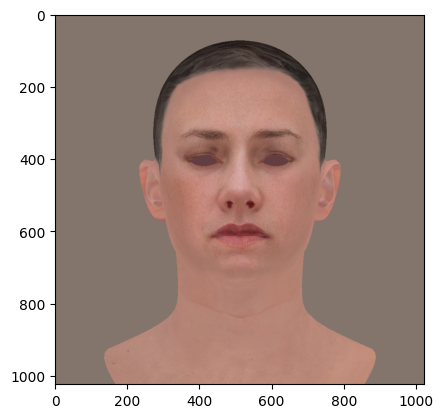

In [45]:
#scaled_verts = deformed_mesh.detach().verts_padded().clone()
scaled_verts = torch.tensor(hack_model.obj_template.vs).clone().to(device).unsqueeze(0)
scale_ = max(scaled_verts[..., 0].max() - scaled_verts[..., 0].min(), scaled_verts[..., 1].max() - scaled_verts[..., 1].min())
scaled_verts[..., :2] /= scale_
scaled_verts[..., :2] += 0.5
scaled_verts[..., 2] -= scaled_verts[..., 2].min()
scaled_verts[..., 2] = scaled_verts[..., 2] / scaled_verts[..., 2].max()
image = render_test(scaled_verts,
                        faces.unsqueeze(0).to(device),
                        new_verts_uvs_coarse.unsqueeze(0),
                        faces.unsqueeze(0),
                        uv_map,image_size=1024
                        )[0].permute(1,2,0).cpu().numpy()
plt.imshow(image)
plt.show()


In [23]:
pytorch3d.io.save_obj("assets/hack_w_HIFI3D_UV.obj",
                      verts=torch.tensor(hack_model.obj_template.vs),
                      faces = faces,
                      verts_uvs =new_verts_uvs_coarse,
                      faces_uvs = faces,
                      texture_map = uv_map[0])
pytorch3d.io.save_obj("assets/hack_m_w_HIFI3D_UV.obj",
                      verts=deformed_mesh.detach().verts_padded().clone()[0],
                      faces = faces,
                      verts_uvs =new_verts_uvs_coarse,
                      faces_uvs = faces,
                      texture_map = uv_map[0])
# torch.save(uv_mapper.state_dict(), "model.pt")

In [108]:
#print(hack_model.obj_template.vs.shape)
# 4400
#debug_faces = trimesh.geometry.triangulate_quads(hack_model.obj_template.fvs[4980:5321])
pytorch3d.io.save_obj("assets/debug.obj",
                      verts=deformed_mesh.detach().verts_padded().clone()[0],
                      faces = faces[4400:5321])